In [1]:
import jax.numpy as np
import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp


from make_trace import MakePulse, apply_noise
from make_pulse import GaussianAmplitude, PolynomialPhase, MultiPulse


In [2]:
pulse_maker = MakePulse(N=128*10, Delta_f=2)

central_f = np.array([0.3])
phase = PolynomialPhase(central_frequency = central_f, coefficients = np.array([0.5, 0, 0, 200]))
amp = GaussianAmplitude(central_frequency = central_f, amplitude = np.array([1.0]), fwhm = np.array([0.2]))
pulse = (amp, phase)

# central_f = np.array([0.3, 0.3])
# phase1 = PolynomialPhase(central_frequency = central_f[0], coefficients = np.array([0.5, 0, -100]))
# phase2 = PolynomialPhase(central_frequency = central_f[1], coefficients = np.array([0.5, 0, 100]))
# pulse = MultiPulse(delay=np.array([100]), duration=np.array([10,10]), central_frequency=central_f, amplitude=np.array([1,1]), phase=[phase, phase])
time_inp, pulse_t_inp, frequency_inp, pulse_f_inp = pulse_maker.generate_pulse(pulse)


central_f = np.array([0.51])
phase = PolynomialPhase(central_frequency = central_f, coefficients = np.zeros(3))
amp = GaussianAmplitude(central_frequency = central_f, amplitude = np.array([1.0]), fwhm = np.array([0.1]))
time_gate, pulse_t_gate, frequency_gate, pulse_f_gate = pulse_maker.generate_pulse((amp, phase))

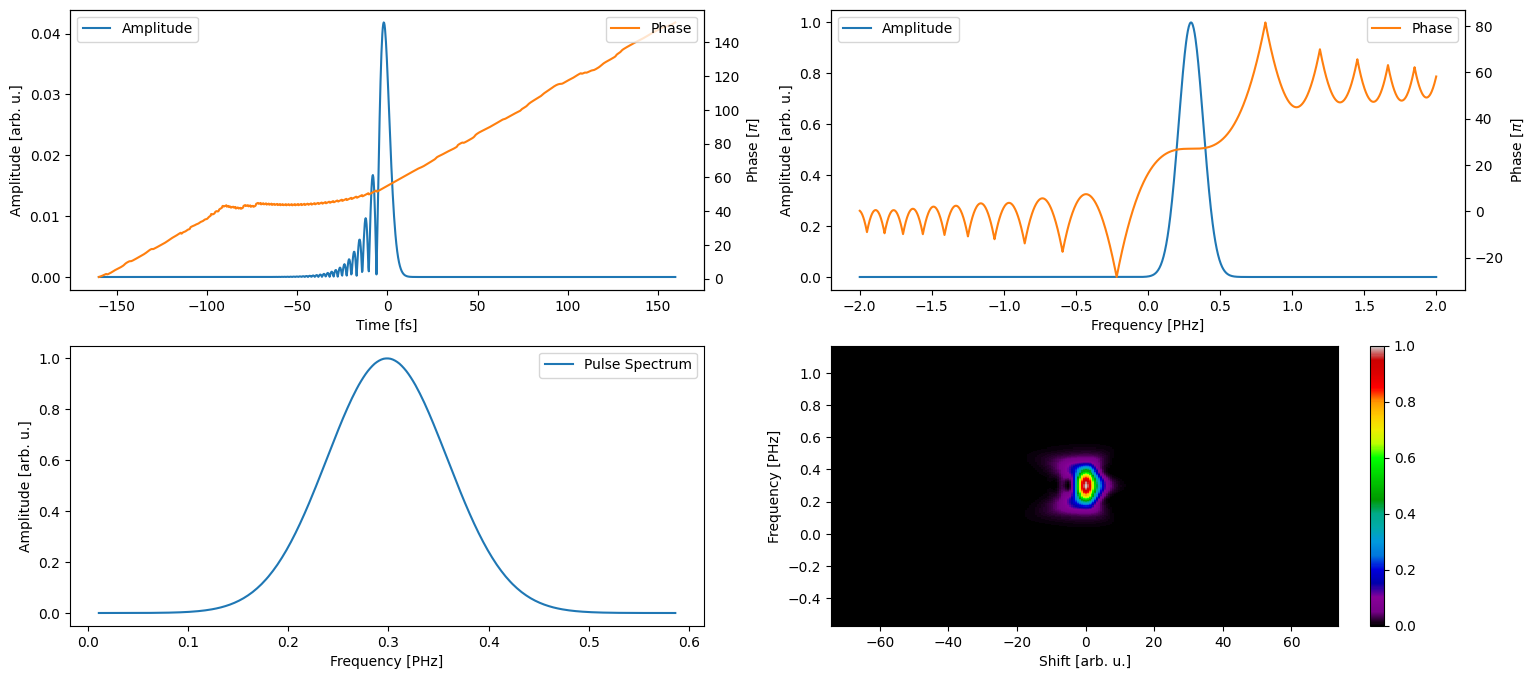

In [3]:
time, frequency, trace, spectra=pulse_maker.generate_frog(time_inp, frequency_inp, pulse_t_inp, pulse_f_inp, nonlinear_method="pg", 
                                                          scale_time_range=4, N=128*2, cross_correlation=False, 
                                                          gate=(frequency_gate, pulse_f_gate),
                                                          interpolate_fft_conform=True, 
                                                          cut_off_val=1e-3, ifrog=False)

#trace = apply_noise(trace, scale_val=(0.05, 0.05), additive_noise=True, multiplicative_noise=True)

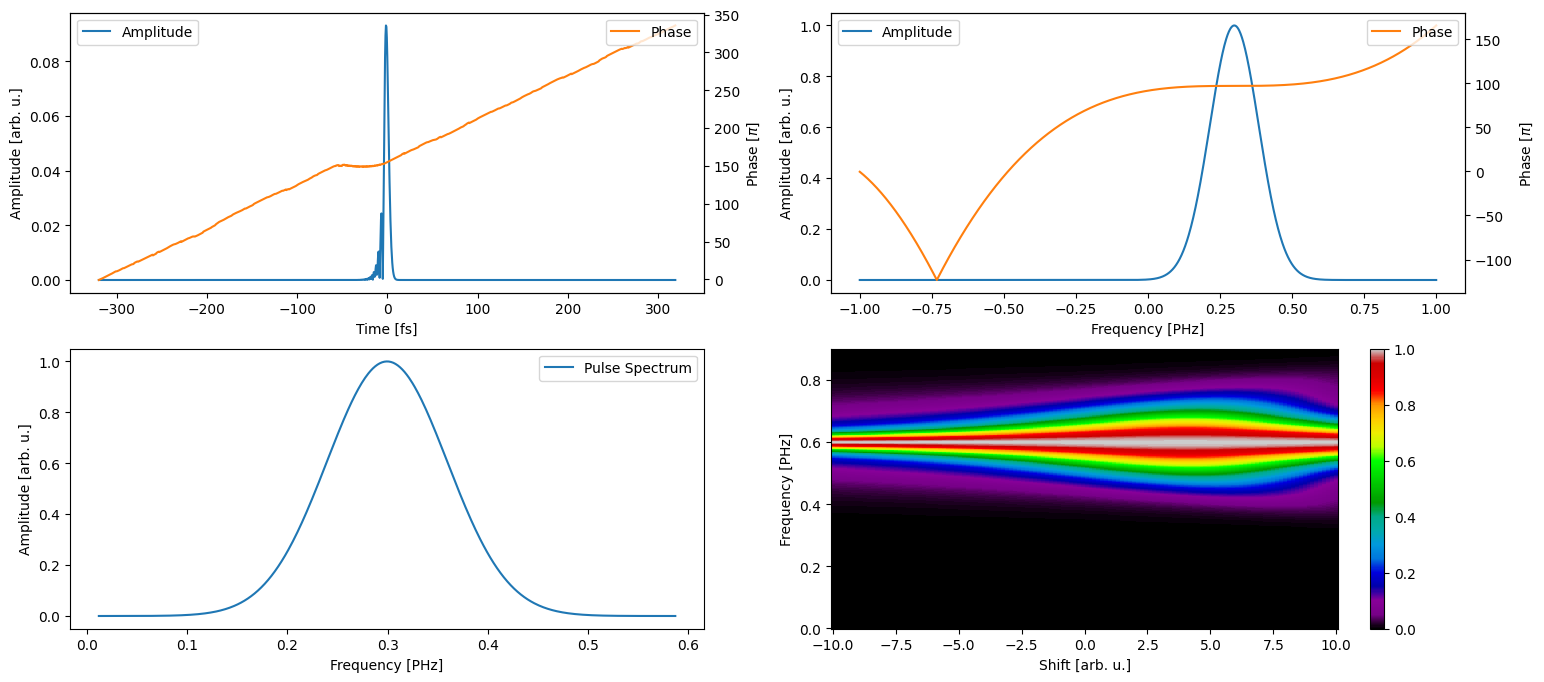

In [ ]:
#from phase_matrix_funcs import parameters_material_scan as parameters, calculate_phase_matrix_miips as phase_matrix_func

pulse_maker = MakePulse(N=128*10, Delta_f=1)

central_f = np.array([0.3])
phase = PolynomialPhase(central_frequency = central_f, coefficients = np.array([0.5, 0, 0, 100]))
amp = GaussianAmplitude(central_frequency = central_f, amplitude = np.array([1.0]), fwhm = np.array([0.2]))
time_inp, pulse_t_inp, frequency_inp, pulse_f_inp = pulse_maker.generate_pulse((amp, phase))




z_arr=np.linspace(-10, 10, 128)
z_arr, frequency, trace, spectra = pulse_maker.generate_chirpscan(z_arr, time_inp, frequency_inp, pulse_t_inp, pulse_f_inp,
                                                              "shg", phase_matrix_func, parameters,
                                                              N=128*4, cut_off_val=1e-3, frequency_range=(0, 0.9))


#trace = apply_noise(trace, scale_val=0.01, additive_noise=True, multiplicative_noise=False)

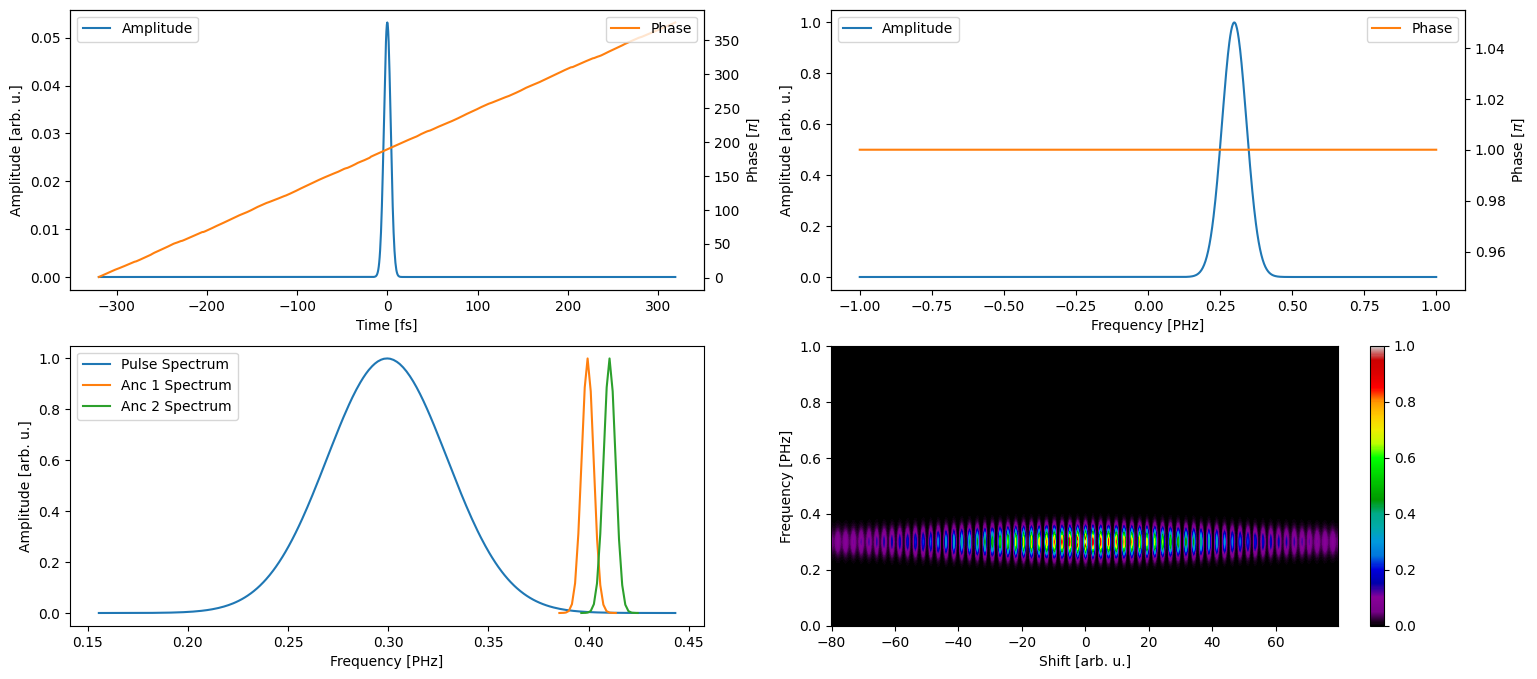

In [6]:
pulse_maker = MakePulse(N=128*10, Delta_f=1)

central_f = np.array([0.3])
phase = PolynomialPhase(central_frequency = central_f, coefficients = np.array([0.5, 0, 000]))
amp = GaussianAmplitude(central_frequency = central_f, amplitude = np.array([1.0]), fwhm = np.array([0.1]))
time_inp, pulse_t_inp, frequency_inp, pulse_f_inp = pulse_maker.generate_pulse((amp, phase))

input_pulses = pulse_maker.pulses



central_f = np.array([0.4])
phase = PolynomialPhase(central_frequency=central_f, coefficients = np.zeros(3))
amp = GaussianAmplitude(central_frequency = central_f, amplitude = np.array([1.0]), fwhm = np.array([0.01]))
_, _, frequency_gate_1, pulse_f_gate_1 = pulse_maker.generate_pulse((amp, phase))


central_f = np.array([0.41])
phase = PolynomialPhase(central_frequency = central_f, coefficients = np.zeros(3))
amp = GaussianAmplitude(central_frequency = central_f, amplitude = np.array([1.0]), fwhm = np.array([0.01]))
_, _, frequency_gate_2, pulse_f_gate_2 = pulse_maker.generate_pulse((amp, phase))




time, frequency, trace, spectra=pulse_maker.generate_2dsi(time_inp, frequency_inp, pulse_t_inp, pulse_f_inp, "pg", cross_correlation=True,
                                                          anc=((frequency_gate_1, pulse_f_gate_1),
                                                               (frequency_gate_2, pulse_f_gate_2)), 
                                                          N=256*4, scale_time_range=0.25, plot_stuff=True, cut_off_val=0.001, frequency_range=(0, 1))




In [13]:
from classic_algorithms_2dsi import DirectReconstruction

In [14]:
dr = DirectReconstruction(time, frequency, trace, "pg", True, 0.4, 0.405).use_measured_spectrum(spectra.pulse[0], spectra.pulse[1])
anc1 = dr.get_anc_pulse(frequency_gate_1, pulse_f_gate_1, anc_no=1)
anc2 = dr.get_anc_pulse(frequency_gate_2, pulse_f_gate_2, anc_no=2)

dr.use_windowing = False#"hamming"

population = dr.create_initial_population(1)
final_result = dr.run(population, no_iterations=1)

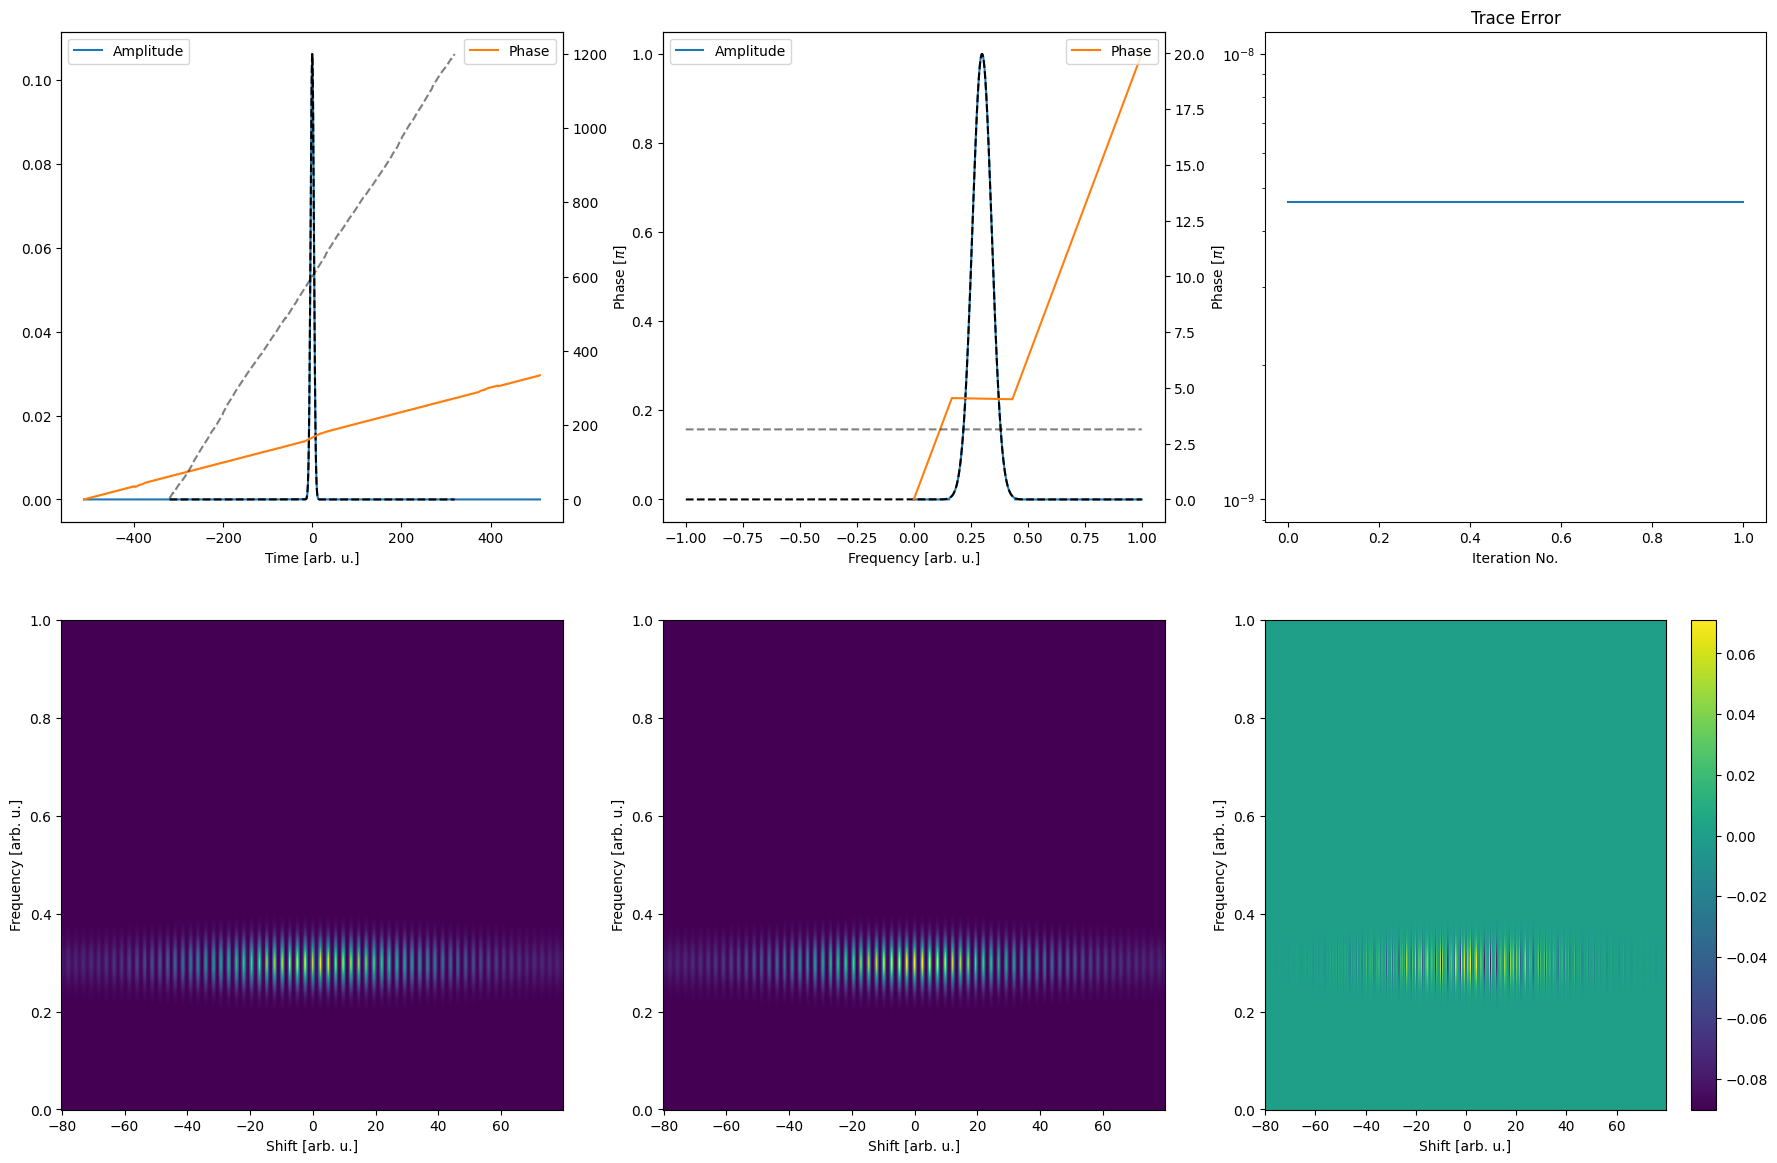

In [15]:
dr.plot_results(final_result, exact_pulse=input_pulses)

In [4]:
from classic_algorithms_frog import Vanilla, LSGPA, GeneralizedProjection, TimeDomainPtychography, COPRA

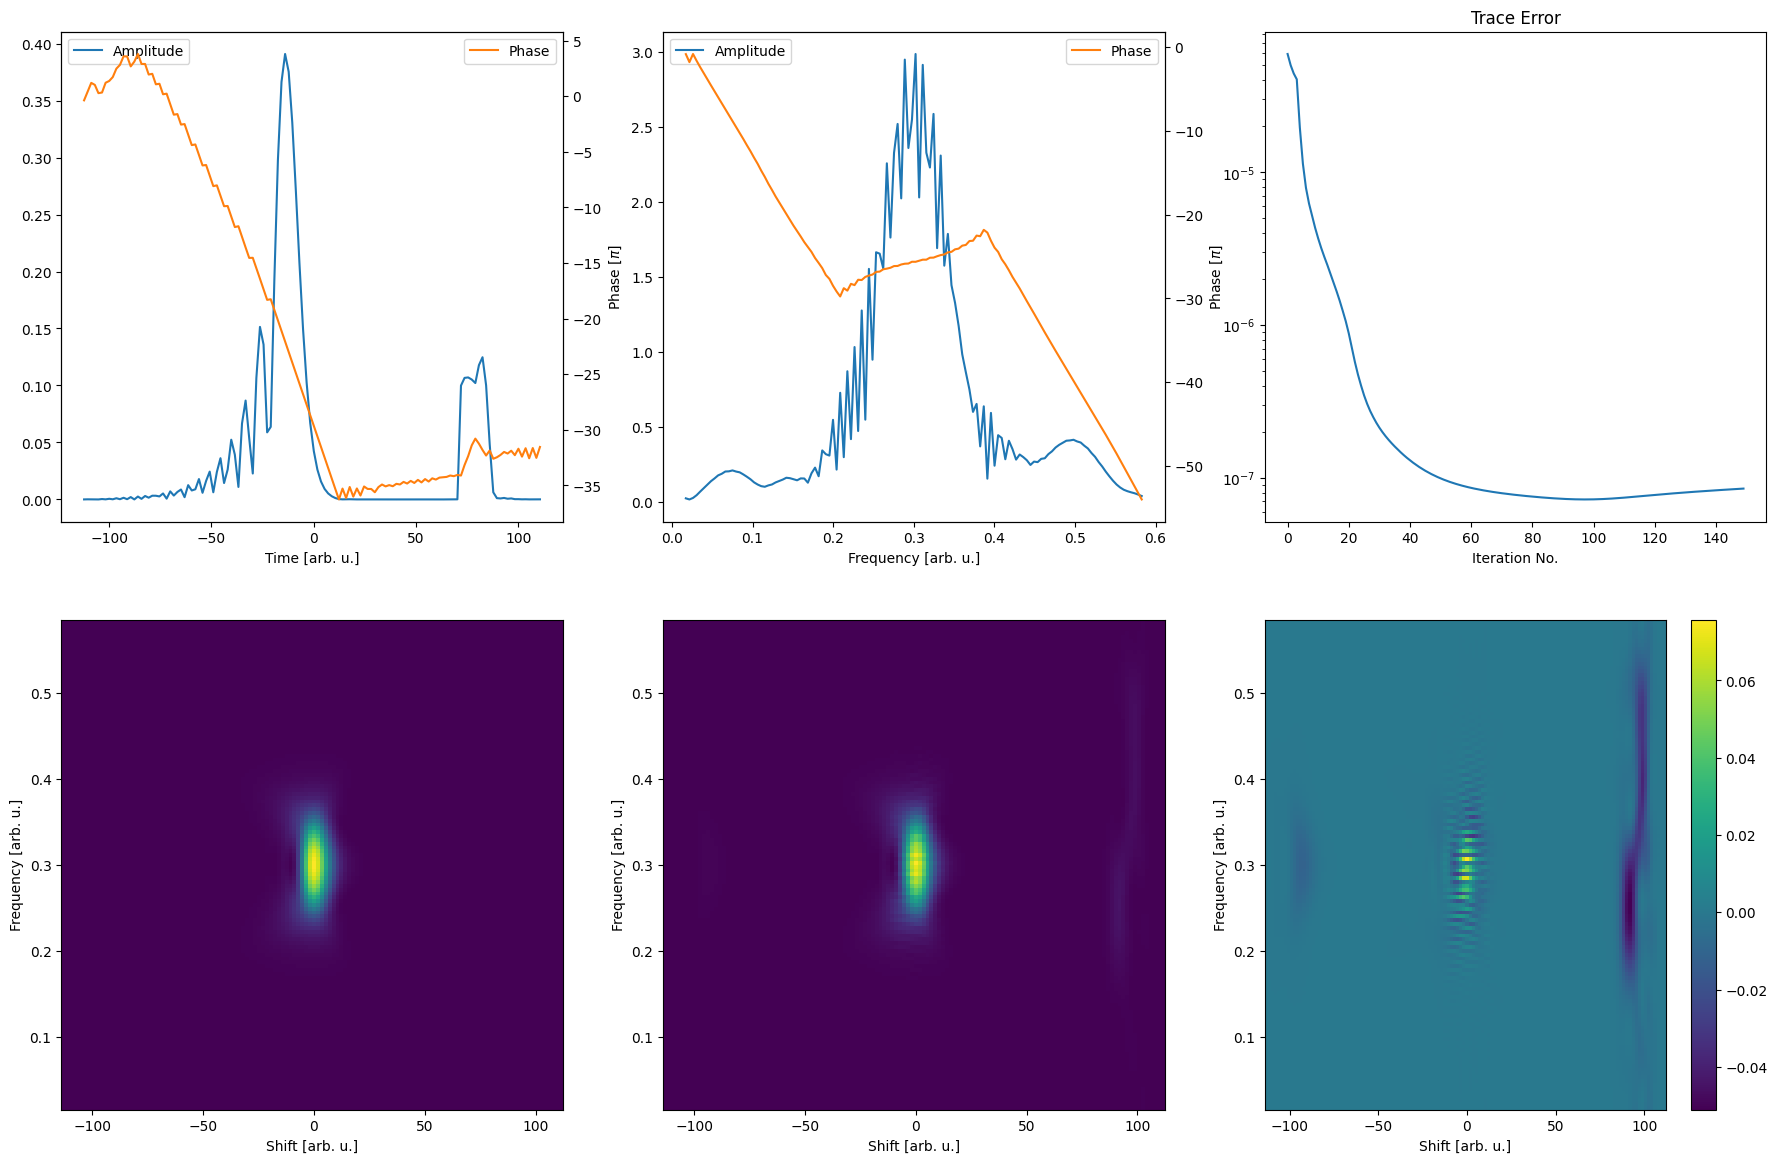

In [ ]:
# vanilla = Vanilla(time, frequency, trace, "pg")
# population = vanilla.create_initial_population(population_size=3, guess_type="random")

# final_result = vanilla.run(population, 100)
# vanilla.plot_results(final_result)






# lsgpa = LSGPA(time, frequency, trace, "pg", cross_correlation=False)#.use_measured_spectrum(spectra.pulse[0], spectra.pulse[1], "pulse")
# population = lsgpa.create_initial_population(population_size=3, guess_type="random")

# final_result = lsgpa.run(population, 500)
# lsgpa.plot_results(final_result)






# gp = GeneralizedProjection(time, frequency, trace, "pg", cross_correlation=False)
# population = gp.create_initial_population(population_size=1, guess_type="random")

# gp.global_hessian = "lbfgs"
# gp.conjugate_gradients = False


# gp.no_steps_descent = 25
# gp.max_steps_linesearch = 15
# gp.use_linesearch = "zoom"
# gp.global_gamma = 1.0
# gp.delta_gamma = 2.0
# gp.c1 = 1e-4
# gp.c2 = 0.5

# # gp.lbfgs_memory = 3

# # gp.use_copra_style_step_scaling = False


# final_result = gp.run(population, 150)
# gp.plot_results(final_result)






# tdp = TimeDomainPtychography(time, frequency, trace, "sd", "ePIE", cross_correlation="doubleblind")
# population = tdp.create_initial_population(population_size=3, guess_type="random")

# tdp.alpha = 0.1
# tdp.local_gamma = 0.1
# tdp.global_gamma = 0.1

# tdp.lbfgs_memory = 15
# tdp.conjugate_gradients = False#"fletcher_reeves"

# tdp.global_hessian = "full" #"lbfgs"
# tdp.use_linesearch = "backtracking" #"wolfe"
# #tdp.lambda_lm = 1e-2

# final_result = tdp.run(population, 0, 150)
# tdp.plot_results(final_result)





# copra = COPRA(time, frequency, trace, "pg", ifrog=False)#, cross_correlation="doubleblind")
# population = copra.create_initial_population(population_size=5, guess_type="random")

# # copra.use_linesearch = False #"wolfe"

# # copra.local_gamma=1
# # copra.global_gamma=0.5
# # copra.local_adaptive_scaling = "original"
# # copra.global_adaptive_scaling = "original"
# # copra.xi=1e-12

# # copra.local_hessian=False
# # copra.global_hessian=False#"full"

# final_result = copra.run(population, 150, 100)
# copra.plot_results(final_result)



In [4]:
from classic_algorithms_chirpscan import Basic, GeneralizedProjection, TimeDomainPtychography, COPRA

ImportError: cannot import name 'calculate_S_prime' from 'utilities' (/home/tillstehling/_All_Algorithms/utilities.py)

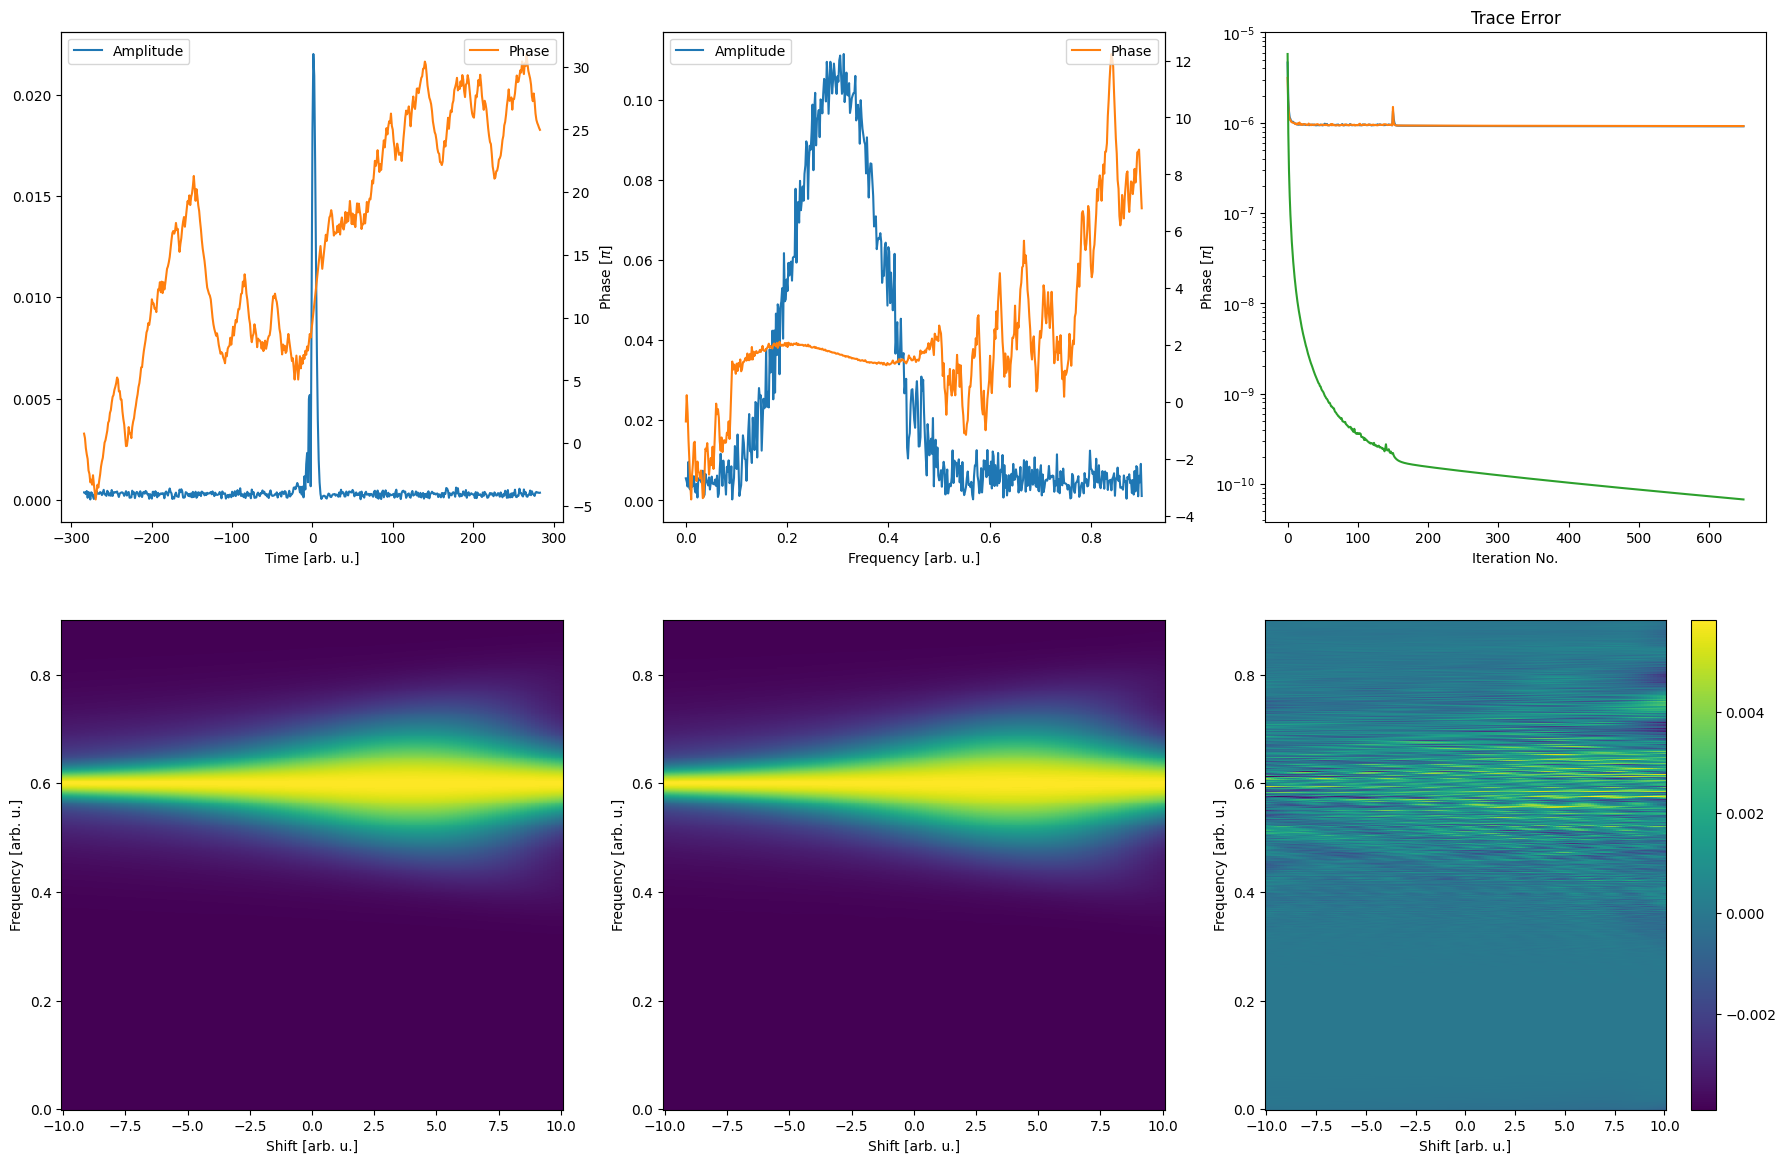

In [ ]:
# basic = Basic(z_arr, frequency, trace, "shg")
# population = basic.create_initial_population(population_size=3, guess_type="random")

# final_result = basic.run(population, 100)
# basic.plot_results(final_result)





# gp = GeneralizedProjection(z_arr, frequency, trace, "shg")
# population = gp.create_initial_population(population_size=3, guess_type="random")

# # gp.global_hessian="lbfgs"#"diagonal"
# # gp.no_steps_descent=50
# # gp.gamma=1

# final_result = gp.run(population, 100)
# gp.plot_results(final_result)




# tdp = TimeDomainPtychography(z_arr, frequency, trace, "shg", pie_method="rPIE", 
#                              phase_matrix_func=phase_matrix_func, chirp_parameters=parameters)
# population = tdp.create_initial_population(population_size=3, guess_type="random")

# tdp.alpha=0.1
# tdp.local_gamma=0.001
# tdp.global_gamma=0.001

# tdp.use_linesearch=False
# tdp.global_hessian=False #"diagonal"

# final_result = tdp.run(population, 500, 0)
# tdp.plot_results(final_result)






copra = COPRA(z_arr, frequency, trace, "shg", phase_matrix_func=phase_matrix_func, chirp_parameters=parameters)
population = copra.create_initial_population(population_size=3, guess_type="random")

copra.local_gamma = 1
copra.global_gamma = 0.25

copra.local_hessian = False
copra.global_hessian = False

copra.local_adaptive_scaling = False
copra.global_adaptive_scaling = False

copra.xi=1e-6

final_result = copra.run(population, 15, 15)
copra.plot_results(final_result)

In [4]:
from general_algorithms_frog import DifferentialEvolution, Evosax, LSF, AutoDiff

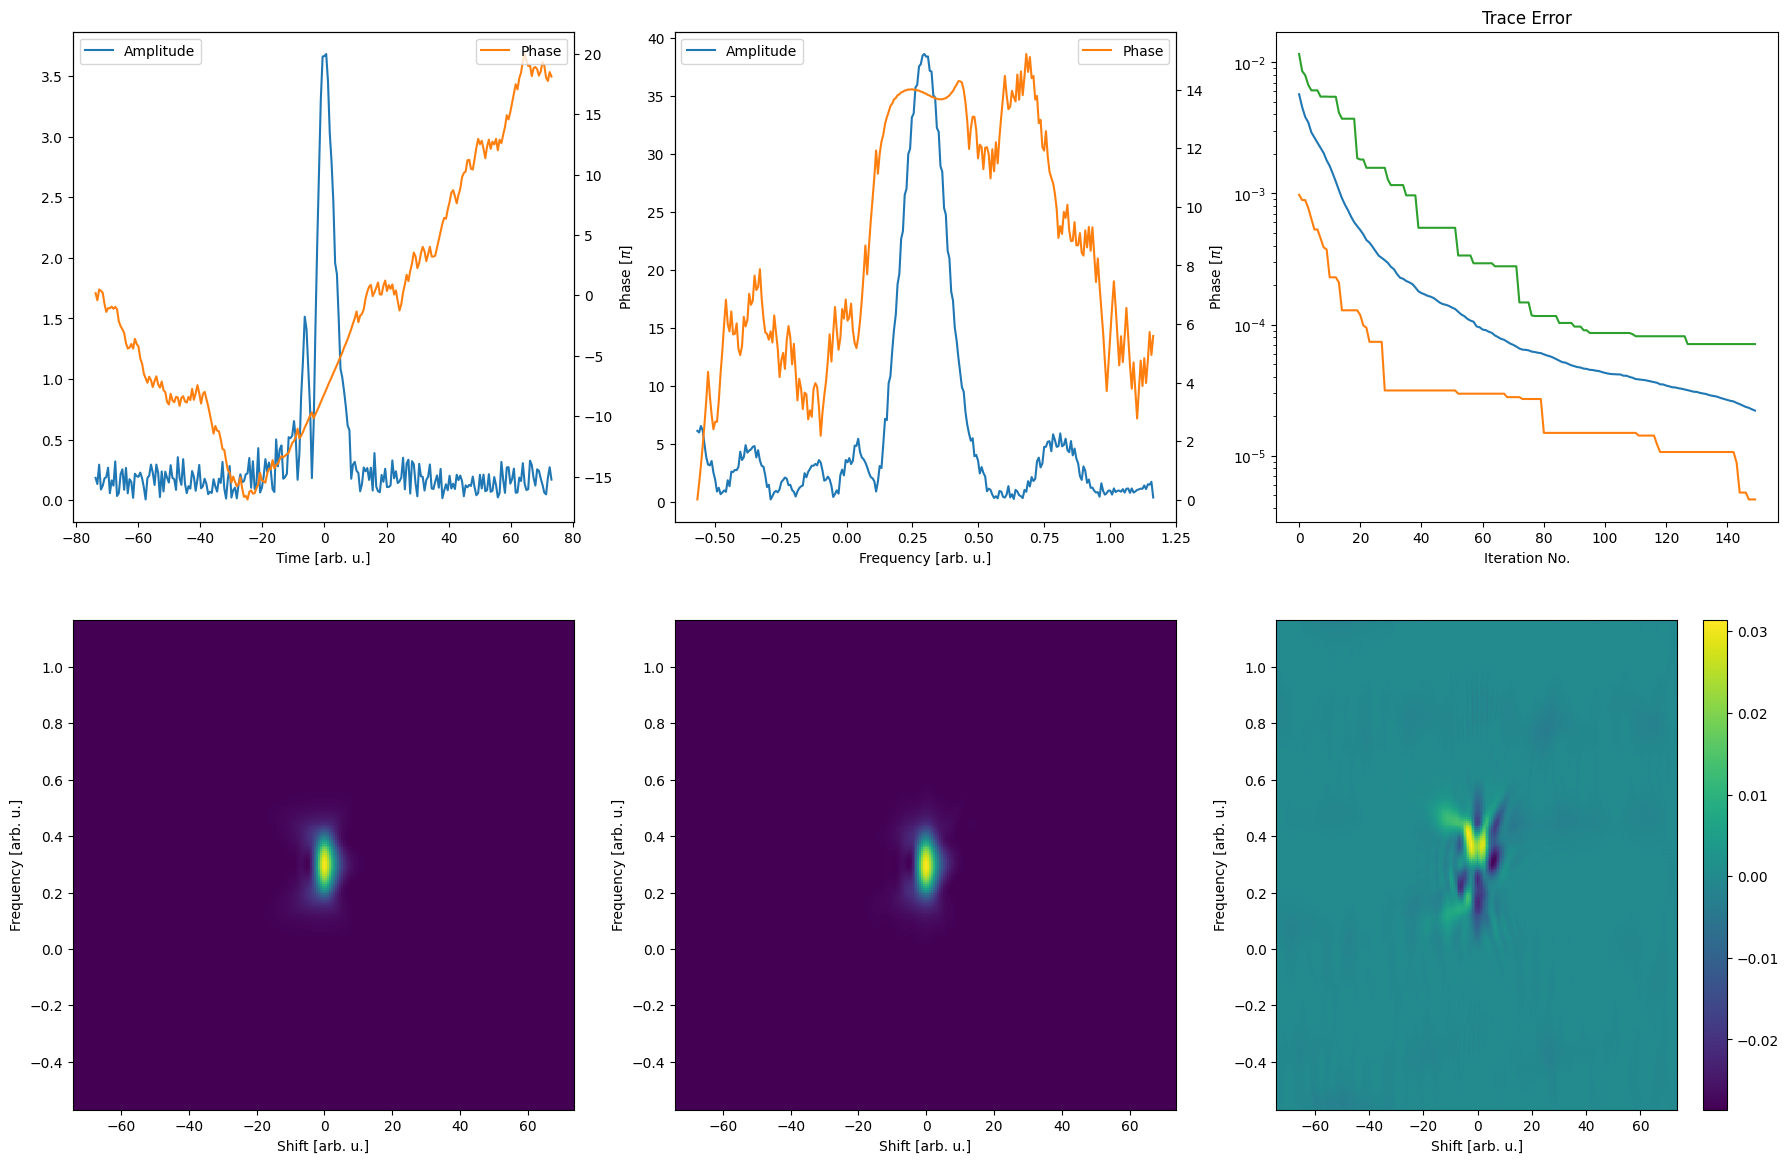

In [33]:
de = DifferentialEvolution(time, frequency, trace, "pg", cross_correlation=False)#.use_measured_spectrum()
#spectral_amplitude = de.get_spectral_amplitude(spectra.pulse[0], spectra.pulse[1], "pulse")
#spectral_amplitude = de.get_spectral_amplitude(spectra.gate[0], spectra.gate[1], "gate")

population = de.create_initial_population(population_size=150, phase_type="bsplines_4", amp_type="bsplines_4", no_funcs_phase=15, no_funcs_amp=15)

de.strategy="best2_bin"

final_result = de.run(population, 150)
de.plot_results(final_result)




# from evosax.algorithms import CMA_ES
# evo = Evosax(time, frequency, trace, "pg", cross_correlation="doubleblind").use_measured_spectrum()
# spectral_amplitude = evo.get_spectral_amplitude(spectra.pulse[0], spectra.pulse[1], "pulse")
# spectral_amplitude = evo.get_spectral_amplitude(spectra.gate[0], spectra.gate[1], "gate")

# population = evo.create_initial_population(population_size=250)

# evo.solver = CMA_ES

# final_result = evo.run(population, 250)
# evo.plot_results(final_result)




# lsf = LSF(time, frequency, trace, "pg", cross_correlation=False).use_measured_spectrum(spectra.pulse[0], spectra.pulse[1], "pulse")

# population = lsf.create_initial_population(population_size=3, amp_type="discrete", phase_type="discrete")

# lsf.number_of_bisection_iterations=12
# lsf.random_direction_mode="random"
# lsf.no_points_for_continuous=5

# final_result = lsf.run(population, 1000)
# lsf.plot_results(final_result)





# ad = AutoDiff(time, frequency, trace, "thg", cross_correlation="doubleblind").use_measured_spectrum()

# spectral_amplitude = ad.get_spectral_amplitude(spectra.pulse[0], spectra.pulse[1], "pulse")
# spectral_amplitude = ad.get_spectral_amplitude(spectra.gate[0], spectra.gate[1], "gate")

# population = ad.create_initial_population(population_size=1, amp_type="discrete", phase_type="discrete")

# ad.alternating_optimization = True
# ad.solver = optax.adam(learning_rate=1e-1)

# final_result = ad.run(population, 1000)
# ad.plot_results(final_result)

In [13]:
from general_algorithms_dscan import DifferentialEvolution, Evosax, LSF, AutoDiff

In [ ]:
# de = DifferentialEvolution(z_arr, frequency, trace, "shg")
# population = de.create_initial_population(population_size=150)

# final_result = de.run(population, 100)
# de.plot_results(final_result)




# from evosax.algorithms import CMA_ES
# evo = Evosax(z_arr, frequency, trace, "shg")
# evo.solver = CMA_ES
# population = evo.create_initial_population(population_size=250)

# final_result = evo.run(population, 100)
# evo.plot_results(final_result)




lsf = LSF(z_arr, frequency, trace, "shg")
population = lsf.create_initial_population(population_size=3, amp_type="random", phase_type="random")

lsf.number_of_bisection_iterations=8
lsf.random_direction_mode="random"
lsf.no_points_for_continuous=15

final_result = lsf.run(population, 2000)
lsf.plot_results(final_result)





# ad = AutoGrad(z_arr, frequency, trace, "shg")
# population = ad.create_initial_population(population_size=1, amp_type="discrete", phase_type="discrete")

# ad.solver=optax.adam(learning_rate=1e-1)

# final_result = ad.run(population, 1000)
# ad.plot_results(final_result)